In [1]:
import os
import sys
sys.path.append("./../")
import numpy as np
import matplotlib.pyplot as plt
import pdb
import pandas as pd
import yaml
import h5py
import vicon_imu_data_process.process_landing_data as pro_rd
import assessments.scores as es_as
import pickle
import seaborn as sns
import copy
import re
import json

from vicon_imu_data_process.const import FEATURES_FIELDS, LABELS_FIELDS, DATA_PATH
from vicon_imu_data_process.const import DROPLANDING_PERIOD, RESULTS_PATH
from vicon_imu_data_process import const
#from vicon_imu_data_process.dataset import *

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
import time as localtimepkg

#from estimation_study import *
#from estimation_assessment.visualization import *
#import pdb
import re
import logging
logging.basicConfig(level=logging.ERROR)

## Analysis the all subjects landing data with and with normalization

In [2]:
all_subjects_trials_dataset,_ = pro_rd.load_subjects_dataset(h5_file_name = os.path.join(DATA_PATH,'all_subjects_landing_data_with_allfeatures.hdf5'))
all_subjects_trials_dataset.keys()

dict_keys(['P_08_zhangboyuan', 'P_09_libang', 'P_10_dongxuan', 'P_11_liuchunyu', 'P_12_fuzijun', 'P_13_xulibang', 'P_14_hunan', 'P_15_liuzhaoyu', 'P_16_zhangjinduo', 'P_17_congyuanqi', 'P_18_hezhonghai', 'P_19_xiongyihui', 'P_20_xuanweicheng', 'P_21_wujianing', 'P_22_zhangning', 'P_23_wangjinhong', 'P_24_liziqing'])

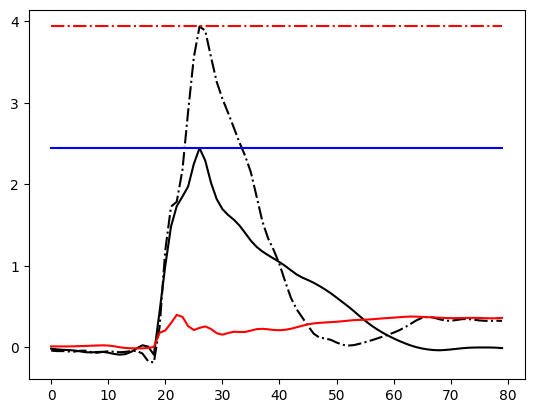

In [3]:
plt.plot(all_subjects_trials_dataset['P_08_zhangboyuan']['05']['R_KNEE_MOMENT_X'],'k-.')
plt.plot(all_subjects_trials_dataset['P_08_zhangboyuan']['05']['PEAK_R_KNEE_MOMENT_X'],'r-.')
plt.plot(all_subjects_trials_dataset['P_14_hunan']['05']['R_KNEE_MOMENT_X'],'k')
plt.plot(all_subjects_trials_dataset['P_14_hunan']['05']['R_KNEE_MOMENT_Y'],'r')
plt.plot(all_subjects_trials_dataset['P_14_hunan']['05']['PEAK_R_KNEE_MOMENT_X'],'b')
#plt.plot(all_subjects_trials_dataset['P_14_hunan']['03']['R_SHANK_Accel_X'][0:],'r')
#plt.plot(all_subjects_trials_dataset['P_14_hunan']['03']['R_SHANK_Accel_Y'][0:],'g')
#plt.plot(all_subjects_trials_dataset['P_14_hunan']['03']['R_SHANK_Accel_Z'][0:],'b')

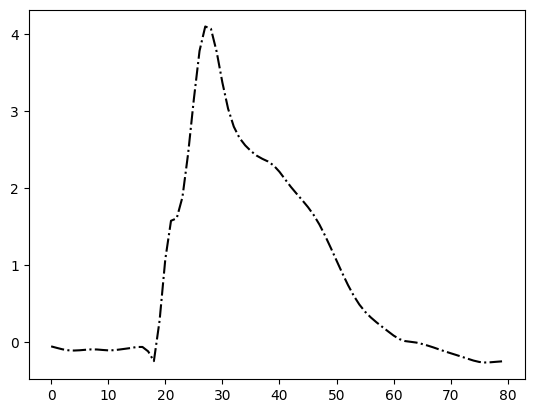

In [4]:
plt.plot(all_subjects_trials_dataset['P_22_zhangning']['01']['R_KNEE_MOMENT_X'],'k-.')

In [6]:
selected_norm_dataset, _ = pro_rd.load_subjects_dataset(h5_file_name = os.path.join(DATA_PATH,'selection/double_leg_norm_landing_data.hdf5'))
print(selected_norm_dataset.keys())
scaler_file = os.path.join(DATA_PATH,'selection/double_leg_landing_scaler_file.pkl')
scaler  = pickle.load(open(scaler_file,'rb'))


dict_keys(['P_08_zhangboyuan', 'P_10_dongxuan', 'P_11_liuchunyu', 'P_13_xulibang', 'P_14_hunan', 'P_15_liuzhaoyu', 'P_16_zhangjinduo', 'P_17_congyuanqi', 'P_18_hezhonghai', 'P_19_xiongyihui', 'P_20_xuanweicheng', 'P_21_wujianing', 'P_22_zhangning', 'P_23_wangjinhong', 'P_24_liziqing'])



columns: Index(['CHEST_Accel_X', 'CHEST_Accel_Y', 'CHEST_Accel_Z', 'CHEST_Gyro_X',
       'CHEST_Gyro_Y', 'CHEST_Gyro_Z', 'CHEST_Mag_X', 'CHEST_Mag_Y',
       'CHEST_Mag_Z', 'WAIST_Accel_X',
       ...
       'THORAX_ANGLE_Z', 'TIME', 'Weight', 'Height', 'PEAK_R_KNEE_MOMENT_X',
       'PEAK_L_KNEE_MOMENT_X', 'PEAK_R_GRF_X', 'PEAK_L_GRF_X', 'PEAK_R_GRF_Z',
       'PEAK_L_GRF_Z'],
      dtype='object', length=137)


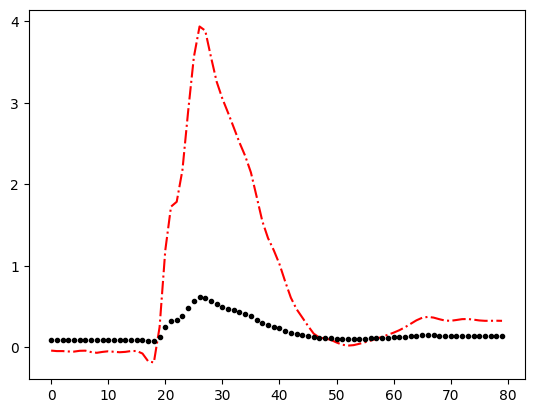

In [15]:
a_subject_name_id = 'P_08_zhangboyuan'
a_trial_id = '05'
data = selected_norm_dataset[a_subject_name_id][a_trial_id]
columns = data.columns
print("columns:",columns)



#plt.plot(data['R_KNEE_MOMENT_X'],'k')

#plt.plot(selected_norm_dataset['P_08_zhangboyuan']['05']['PEAK_R_KNEE_MOMENT_X'],'r-.')
#plt.plot(selected_norm_dataset['P_14_hunan']['05']['R_KNEE_MOMENT_X'],'k')
innorm_data=scaler.inverse_transform(data)

innorm_data = pd.DataFrame(innorm_data,columns=columns)
plt.plot(innorm_data['R_KNEE_MOMENT_X'],'r-.')
plt.plot(data['R_KNEE_MOMENT_X'],'k.')

#plt.plot(innorm_data['Weight'],'r-')
#plt.plot(data['Weight'],'r.')



In [17]:
dtest=all_subjects_trials_dataset['P_14_hunan']['03']['CHEST_Accel_X']
print(dtest.abs().max())

#maxCol=lambda x: max(min(x), max(x), key=abs)
#dtest.apply(maxCol)

xx=pd.DataFrame(data=[[1,2,3],[-5,2,7]])
print(xx.abs().max())

print(xx.min())

2.257342044748074
0    5
1    2
2    7
dtype: int64
0   -5
1    2
2    3
dtype: int64


In [18]:
plt.plot(kam_subjects_trials_dataset['P_14_hunan']['03']['R_KNEE_MOMENT_Y'],'k')
plt.plot(kam_subjects_trials_dataset['P_14_hunan']['03']['CHEST_Accel_X'])
plt.plot(kam_subjects_trials_dataset['P_14_hunan']['03']['CHEST_Accel_Y'])
plt.plot(kam_subjects_trials_dataset['P_14_hunan']['03']['CHEST_Accel_Z'])

NameError: name 'kam_subjects_trials_dataset' is not defined

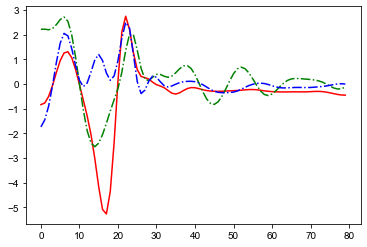

In [5]:
plt.plot(subjects_trials_dataset['P_19_xiongyihui']['02']['R_FOOT_Accel_X'],'r-')
plt.plot(subjects_trials_dataset['P_20_xuanweicheng']['03']['R_FOOT_Accel_X'],'g-.')
plt.plot(subjects_trials_dataset['P_16_zhangjinduo']['04']['R_FOOT_Accel_X'],'b-.')

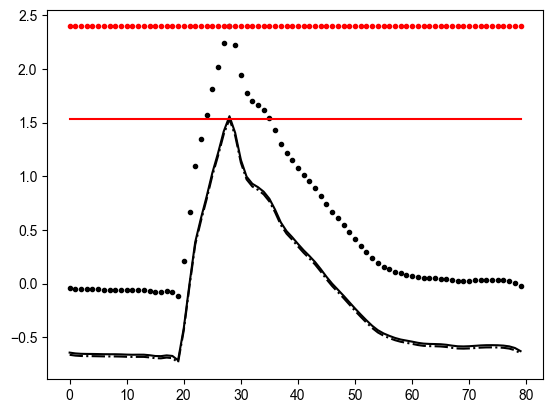

In [83]:
pall_subjects_trials_dataset = pro_rd.load_subjects_dataset(h5_file_name = os.path.join(DATA_PATH,'all_subjects_landing_data_withpeak.hdf5'))
kem_subjects_trials_dataset = pro_rd.load_subjects_dataset(h5_file_name = os.path.join(DATA_PATH,'selection','selection_15sub_25tri_kem_norm_landing_data.hdf5'))
pkem_subjects_trials_dataset = pro_rd.load_subjects_dataset(h5_file_name = os.path.join(DATA_PATH,'selection','selection_15sub_25tri_pkem_norm_landing_data.hdf5'))

plt.plot(all_subjects_trials_dataset['P_14_hunan']['03']['R_KNEE_MOMENT_X'],'k')
plt.plot(pall_subjects_trials_dataset['P_14_hunan']['03']['R_KNEE_MOMENT_X'],'k.')
plt.plot(kem_subjects_trials_dataset['P_14_hunan']['03']['R_KNEE_MOMENT_X'],'k-.')
plt.plot(pkem_subjects_trials_dataset['P_14_hunan']['03']['PEAK_R_KNEE_MOMENT_X'],'r')
plt.plot(pall_subjects_trials_dataset['P_14_hunan']['03']['PEAK_R_KNEE_MOMENT_X'],'r.')
#plt.plot(kem_subjects_trials_dataset['P_14_hunan']['03']['CHEST_Accel_X'])
#plt.plot(kem_subjects_trials_dataset['P_14_hunan']['03']['CHEST_Accel_Y'])
#plt.plot(kem_subjects_trials_dataset['P_14_hunan']['03']['CHEST_Accel_Z'])


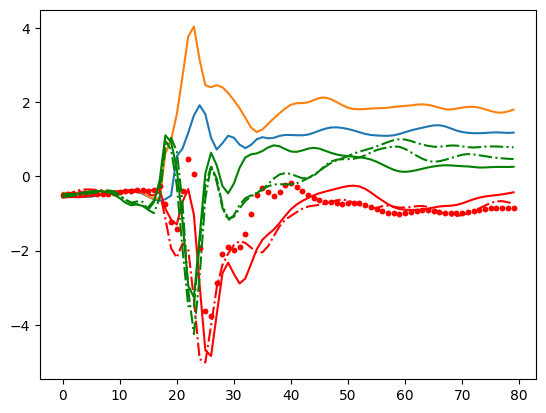

In [41]:
#plt.plot(kem_subjects_trials_dataset['P_14_hunan']['03']['R_KNEE_MOMENT_X'],'k')
plt.plot(kam_subjects_trials_dataset['P_14_hunan']['03']['R_KNEE_MOMENT_Y'])
plt.plot(kam_subjects_trials_dataset['P_14_hunan']['04']['R_KNEE_MOMENT_Y'])
plt.plot(kam_subjects_trials_dataset['P_08_zhangboyuan']['03']['R_KNEE_MOMENT_Y'],'r')
plt.plot(kam_subjects_trials_dataset['P_08_zhangboyuan']['04']['R_KNEE_MOMENT_Y'],'r-.')
plt.plot(kam_subjects_trials_dataset['P_08_zhangboyuan']['05']['R_KNEE_MOMENT_Y'],'r.')
plt.plot(kam_subjects_trials_dataset['P_08_zhangboyuan']['05']['R_KNEE_MOMENT_Y'],'r.')
plt.plot(kam_subjects_trials_dataset['P_11_liuchunyu']['05']['R_KNEE_MOMENT_Y'],'g-')
plt.plot(kam_subjects_trials_dataset['P_11_liuchunyu']['02']['R_KNEE_MOMENT_Y'],'g-.')
plt.plot(kam_subjects_trials_dataset['P_11_liuchunyu']['01']['R_KNEE_MOMENT_Y'],'g-.')


In [134]:
# augmentation dataset

aug0_kem_subjects_trials_dataset = pro_rd.load_subjects_dataset(h5_file_name = os.path.join(DATA_PATH,'augmentation','augmentation_6rotid_15sub_25tri_kem_norm_landing_data.hdf5'))
aug1_kem_subjects_trials_dataset = pro_rd.load_subjects_dataset(h5_file_name = os.path.join(DATA_PATH,'augmentation','augmentation_7rotid_15sub_25tri_kem_norm_landing_data.hdf5'))
aug2_kem_subjects_trials_dataset = pro_rd.load_subjects_dataset(h5_file_name = os.path.join(DATA_PATH,'augmentation','augmentation_8rotid_15sub_25tri_kem_norm_landing_data.hdf5'))
aug3_kem_subjects_trials_dataset = pro_rd.load_subjects_dataset(h5_file_name = os.path.join(DATA_PATH,'augmentation','augmentation_9rotid_15sub_25tri_kem_norm_landing_data.hdf5'))

dict_keys(['01_0', '01_1', '01_2', '01_3', '01_4', '01_5', '01_6', '01_7', '01_8', '02_0', '02_1', '02_2', '02_3', '02_4', '02_5', '02_6', '02_7', '02_8', '03_0', '03_1', '03_2', '03_3', '03_4', '03_5', '03_6', '03_7', '03_8', '04_0', '04_1', '04_2', '04_3', '04_4', '04_5', '04_6', '04_7', '04_8', '05_0', '05_1', '05_2', '05_3', '05_4', '05_5', '05_6', '05_7', '05_8', '06_0', '06_1', '06_2', '06_3', '06_4', '06_5', '06_6', '06_7', '06_8', '07_0', '07_1', '07_2', '07_3', '07_4', '07_5', '07_6', '07_7', '07_8', '08_0', '08_1', '08_2', '08_3', '08_4', '08_5', '08_6', '08_7', '08_8', '09_0', '09_1', '09_2', '09_3', '09_4', '09_5', '09_6', '09_7', '09_8', '10_0', '10_1', '10_2', '10_3', '10_4', '10_5', '10_6', '10_7', '10_8', '11_0', '11_1', '11_2', '11_3', '11_4', '11_5', '11_6', '11_7', '11_8', '12_0', '12_1', '12_2', '12_3', '12_4', '12_5', '12_6', '12_7', '12_8', '13_0', '13_1', '13_2', '13_3', '13_4', '13_5', '13_6', '13_7', '13_8', '14_0', '14_1', '14_2', '14_3', '14_4', '14_5', '14_6

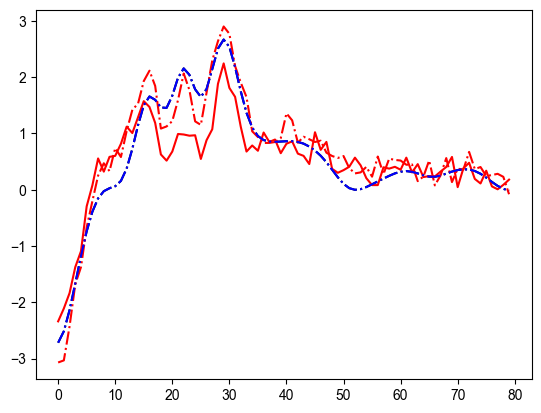

In [136]:
plt.plot(kem_subjects_trials_dataset['P_11_liuchunyu']['01']['CHEST_Accel_X'],'k-.')
plt.plot(aug0_kem_subjects_trials_dataset['P_11_liuchunyu']['01_0']['CHEST_Accel_X'],'r-.')
plt.plot(aug1_kem_subjects_trials_dataset['P_11_liuchunyu']['01_0']['CHEST_Accel_X'],'r-')
plt.plot(aug3_kem_subjects_trials_dataset['P_11_liuchunyu']['01']['CHEST_Accel_X'],'b-.')
#plt.plot(aug2_kem_subjects_trials_dataset['P_11_liuchunyu']['01 ']['CHEST_Accel_X'],'b-')
aug2_kem_subjects_trials_dataset['P_11_liuchunyu'].keys()

In [11]:
subjects_trials_dataset, _ = pro_rd.load_subjects_dataset(h5_file_name = os.path.join(DATA_PATH,'selected_data','5trials_8subjects_kam_norm_landing_data.hdf5'))
pro_rd.get_subjects_trials_number(subjects_trials_dataset)


subjects_trials_dataset,_ = pro_rd.load_subjects_dataset(h5_file_name = os.path.join(DATA_PATH,'selected_data','5trials_9subjects_kam_norm_landing_data.hdf5'))
pro_rd.get_subjects_trials_number(subjects_trials_dataset)


subjects_trials_dataset,_ = pro_rd.load_subjects_dataset(h5_file_name = os.path.join(DATA_PATH,'selected_data','5trials_10subjects_kam_norm_landing_data.hdf5'))
pro_rd.get_subjects_trials_number(subjects_trials_dataset)

subjects_trials_dataset,_ = pro_rd.load_subjects_dataset(h5_file_name = os.path.join(DATA_PATH,'selected_data','5trials_15subjects_kam_norm_landing_data.hdf5'))
pro_rd.get_subjects_trials_number(subjects_trials_dataset)


subjects_trials_dataset,_ = pro_rd.load_subjects_dataset(h5_file_name = os.path.join(DATA_PATH,'selected_data','5trials_16subjects_kam_norm_landing_data.hdf5'))
pro_rd.get_subjects_trials_number(subjects_trials_dataset)


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/media/sun/TFcard/drop_landing_workspace/data/selected_data/5trials_8subjects_kam_norm_landing_data.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

    CHEST_Accel_X  CHEST_Accel_Y  CHEST_Accel_Z  CHEST_Gyro_X  CHEST_Gyro_Y  \
0       -1.387034       2.796255      -0.943298     -1.012042     -0.593076   
1       -0.788792       1.650273      -0.432814     -1.190595     -0.571663   
2        0.049729       0.597362       0.046089     -1.359866     -0.517272   
3        0.953678      -0.193470       0.502562     -1.501775     -0.429679   
4        1.728718      -0.596759       0.947735     -1.607957     -0.314797   
..            ...            ...            ...           ...           ...   
75       0.249407       4.379273      -3.144011     -1.543844     -0.303939   
76       0.190592       4.455357      -3.067809     -1.548259     -0.329551   
77       0.138214       4.555784      -3.089730     -1.546108     -0.351160   
78       0.101052       4.680064      -3.211987     -1.534672     -0.368183   
79       0.076490       4.832594      -3.419622     -1.508967     -0.383165   

    CHEST_Gyro_Z  CHEST_Mag_X  CHEST_Mag_Y  CHEST_M

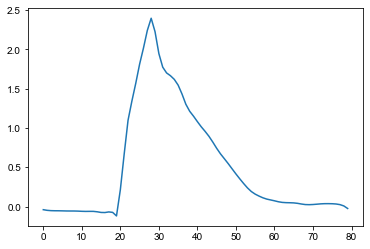

In [22]:

print(all_subjects_trials_dataset['P_14_hunan']['03'])
plt.plot(all_subjects_trials_dataset['P_14_hunan']['03']['R_KNEE_MOMENT_X'])

In [35]:
v2_augment_subjects_trials_dataset = pro_rd.load_subjects_dataset(h5_file_name = os.path.join(DATA_PATH,'v2_2_5d_augment_kam_norm_landing_data.hdf5'))
#print(subjects_trials_dataset['P_08_zhangboyuan'].keys())
v2_augment_subjects_trials_dataset['P_08_zhangboyuan']['01_17']

,CHEST_Accel_X,CHEST_Accel_Y,CHEST_Accel_Z,CHEST_Gyro_X,CHEST_Gyro_Y,CHEST_Gyro_Z,WAIST_Accel_X,WAIST_Accel_Y,WAIST_Accel_Z,WAIST_Gyro_X,...,L_SHANK_Gyro_Y,L_SHANK_Gyro_Z,L_FOOT_Accel_X,L_FOOT_Accel_Y,L_FOOT_Accel_Z,L_FOOT_Gyro_X,L_FOOT_Gyro_Y,L_FOOT_Gyro_Z,TIME,R_KNEE_MOMENT_X
0,-0.307743,-0.848483,0.886402,0.201739,0.832931,0.105811,-0.409672,-0.812233,1.219347,-0.198479,...,2.015743,1.318920,0.007890,0.214291,-0.785808,0.429048,0.295970,2.494976,-1.710534,-0.681864
1,-0.280371,-0.802816,0.910427,0.093627,0.909836,0.041653,-0.465538,-0.866906,1.214529,-0.323971,...,1.773624,1.277570,-0.293376,0.304545,-0.716163,0.365726,0.239581,2.377982,-1.667229,-0.680241
2,-0.244814,-0.774021,0.932067,-0.034777,1.001446,-0.023239,-0.396340,-0.895519,1.198755,-0.399684,...,1.428282,1.243045,-0.618836,0.289109,-0.761043,0.267304,0.078228,2.204453,-1.623924,-0.679721
3,-0.198346,-0.760491,0.951081,-0.182230,1.079027,-0.081435,-0.227489,-0.894633,1.179919,-0.439617,...,1.038673,1.210406,-0.950486,0.218353,-0.899204,0.184937,-0.161500,1.963400,-1.580620,-0.682034
4,-0.135312,-0.757351,0.966908,-0.341787,1.115470,-0.128699,-0.006415,-0.867088,1.165251,-0.464982,...,0.664248,1.170919,-1.246950,0.150590,-1.085972,0.147702,-0.440947,1.657702,-1.537315,-0.685047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.257972,-0.011182,1.133225,-0.240339,0.062359,0.207354,0.574025,-0.042988,0.564440,-0.109085,...,-0.121612,-0.045492,0.296214,-0.262877,0.444766,0.206899,-0.125350,-0.158966,1.537315,-0.343186
76,0.193218,-0.036154,1.121625,-0.263476,0.030059,0.221108,0.580499,-0.065291,0.558010,-0.068496,...,-0.077985,-0.053130,0.301120,-0.265009,0.442733,0.199733,-0.131683,-0.150144,1.580620,-0.353327
77,0.127517,-0.056372,1.109515,-0.268156,0.006586,0.222826,0.571514,-0.079616,0.539181,-0.021621,...,-0.036555,-0.063215,0.313075,-0.269360,0.440253,0.193788,-0.134216,-0.142295,1.623924,-0.360142
78,0.067892,-0.071170,1.097860,-0.254249,-0.007835,0.216033,0.549768,-0.084547,0.509169,0.025668,...,-0.013909,-0.073312,0.328938,-0.275995,0.437672,0.189357,-0.131502,-0.137383,1.667229,-0.366597


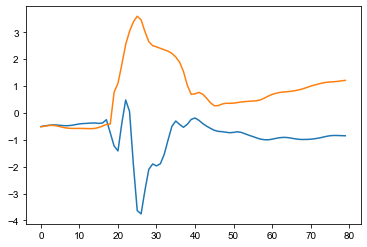

In [31]:
kym_subjects_trials_dataset = pro_rd.load_subjects_dataset(h5_file_name = os.path.join(DATA_PATH,'selected_data', "5trials_15subjects_kym_norm_landing_data.hdf5"))
#print(subjects_trials_dataset['P_08_zhangboyuan'].keys())
kym_subjects_trials_dataset['P_08_zhangboyuan']['01']

plt.plot(kym_subjects_trials_dataset['P_08_zhangboyuan']['05']['R_KNEE_MOMENT_Y'])
plt.plot(kym_subjects_trials_dataset['P_14_hunan']['09']['R_KNEE_MOMENT_Y'])

In [24]:
print(kym_subjects_trials_dataset['P_08_zhangboyuan'].keys())

dict_keys(['01', '02', '03', '04', '05'])


In [52]:
import itertools
import random
N=15
summ=0
for n1 in range(1,14):
    n1=2
    li=sorted(list(range(N)))
    co=list(itertools.combinations(li,n1))
    summ+=len(random.sample(co,15))
    for 
print(summ)

['P_10_dongxuan',
 'P_11_liuchunyu',
 'P_13_xulibang',
 'P_14_hunan',
 'P_15_liuzhaoyu',
 'P_16_zhangjinduo',
 'P_17_congyuanqi',
 'P_18_hezhonghai',
 'P_19_xiongyihui',
 'P_20_xuanweicheng',
 'P_21_wujianing',
 'P_22_zhangning',
 'P_23_wangjinhong',
 'P_24_liziqing']

# Validate the peak values (peak knee moment)

In [41]:
all_subjects_trials_dataset = pro_rd.load_subjects_dataset(h5_file_name = os.path.join(DATA_PATH,'selection','selection_15sub_20tri_kem_norm_landing_data.hdf5'))
all_subjects_trials_dataset.keys()

ss=generate_peak_value(all_subjects_trials_dataset,['R_KNEE_MOMENT_X'],'selection/selection_15sub_20tri_pkem_norm_landing_data.hdf5')

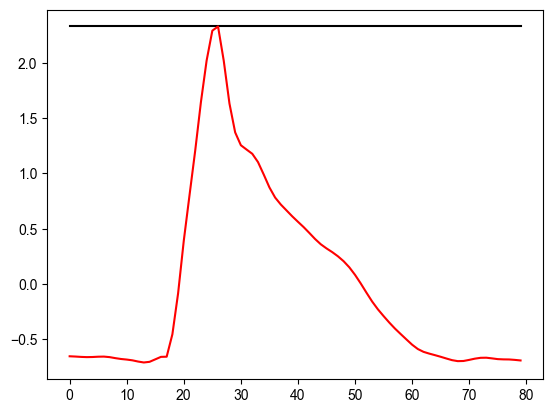

In [42]:

plt.plot(ss['P_14_hunan']['04']['PEAK_R_KNEE_MOMENT_X'],'k')
plt.plot(ss['P_14_hunan']['04']['R_KNEE_MOMENT_X'],'r')
#plt.plot(ss['P_14_hunan']['04']['PEAK_R_GRF_X'],'k-.')
#plt.plot(ss['P_14_hunan']['04']['R_GRF_X'],'r.-')

## IMU data augmentation code

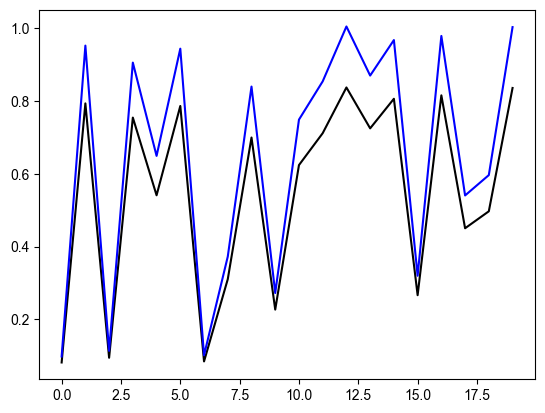

In [70]:
import numpy as np
from scipy import signal

def flip_data(data):
    # Flips the data along the x-axis
    return np.flip(data, axis=0)



def rotate_data(data, angle):
    # Rotates the data around the z-axis by a specified angle
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle), 0],
                                [np.sin(angle), np.cos(angle), 0],
                                [0, 0, 1]])
    return np.dot(data, rotation_matrix.T)


def add_noise(data, noise_level):
    # Adds Gaussian noise to the data
    noise = np.random.normal(0, noise_level, size=data.shape)
    return data + noise

def shift_data(data, shift):
    # Shifts the data along the time axis
    return np.roll(data, shift, axis=0)

def scale_magnitude(data, scale_factor):
    # Scales the magnitude of the data
    magnitudes = np.linalg.norm(data, axis=1)
    scaled_magnitudes = magnitudes * scale_factor
    scaled_data = data / magnitudes[:, None] * scaled_magnitudes[:, None]
    return scaled_data

# Example usage
imu_data = np.sin(np.random.rand(20, 6))  # Example IMU data array
flipped_data = flip_data(imu_data)
#rotated_data = rotate_data(imu_data, np.pi/4)
noisy_data = add_noise(imu_data, 0.1)
shifted_data = shift_data(imu_data, 5)
scaled_data = scale_magnitude(imu_data, 1.2)

plt.plot(imu_data[:,0],'k')
#plt.plot(flipped_data[:,0],'r')
#plt.plot(noisy_data[:,0],'g')
#plt.plot(shifted_data[:,0],'b')
plt.plot(scaled_data[:,0],'b')

## Load measured data and augmented datas

In [19]:
# load the selected subjects data
subject_num=15; trial_num=25
base_name = "norm_landing_data.hdf5"
prefix_name = "double_leg_"
h5_file_name = os.path.join(DATA_PATH,"selection",prefix_name+base_name)
print(h5_file_name)
measured_subjects_trials_data, _= pro_rd.load_subjects_dataset(h5_file_name=h5_file_name)


# load the augmented subjects data
base_name = "norm_landing_data.hdf5"
prefix_name = "6rotid_double_leg_"
h5_file_name = os.path.join(DATA_PATH,"augmentation",prefix_name+base_name)
print(h5_file_name)
augmented_subjects_trials_data, _ = pro_rd.load_subjects_dataset(h5_file_name=h5_file_name)


/media/suntao/DATA/drop_landing_workspace/data/selection/double_leg_norm_landing_data.hdf5
/media/suntao/DATA/drop_landing_workspace/data/augmentation/6rotid_double_leg_norm_landing_data.hdf5


In [20]:
a_subject = 'P_08_zhangboyuan'
print(measured_subjects_trials_data[a_subject].keys())
print(augmented_subjects_trials_data[a_subject].keys())

dict_keys(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30'])
dict_keys(['01', '01_0', '01_1', '01_2', '01_3', '01_4', '01_5', '01_6', '01_7', '01_8', '02', '02_0', '02_1', '02_2', '02_3', '02_4', '02_5', '02_6', '02_7', '02_8', '03', '03_0', '03_1', '03_2', '03_3', '03_4', '03_5', '03_6', '03_7', '03_8', '04', '04_0', '04_1', '04_2', '04_3', '04_4', '04_5', '04_6', '04_7', '04_8', '05', '05_0', '05_1', '05_2', '05_3', '05_4', '05_5', '05_6', '05_7', '05_8', '06', '06_0', '06_1', '06_2', '06_3', '06_4', '06_5', '06_6', '06_7', '06_8', '07', '07_0', '07_1', '07_2', '07_3', '07_4', '07_5', '07_6', '07_7', '07_8', '08', '08_0', '08_1', '08_2', '08_3', '08_4', '08_5', '08_6', '08_7', '08_8', '09', '09_0', '09_1', '09_2', '09_3', '09_4', '09_5', '09_6', '09_7', '09_8', '10', '10_0', '10_1', '10_2', '10_3', '10_4', '10_5', '10_6', '10_7', '10_8', '11', '11_0', '11

### Compare curves of the measured and augmentation data

aug num of a trial: 300
150


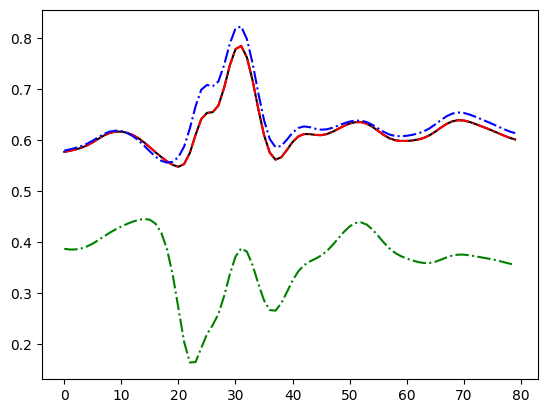

In [30]:
subject_id_name='P_08_zhangboyuan'
trial_id='01'
mdata = measured_subjects_trials_data[subject_id_name][trial_id]

aug_num_of_a_trial = len(augmented_subjects_trials_data[subject_id_name].keys())
print("aug num of a trial:", aug_num_of_a_trial)
nonrot_trial_idx=int(round((aug_num_of_a_trial-1)/2+1))
print(nonrot_trial_idx)

adata_1 = augmented_subjects_trials_data[subject_id_name][trial_id]
adata_2 = augmented_subjects_trials_data[subject_id_name][trial_id+'_'+str(0)]
adata_3 = augmented_subjects_trials_data[subject_id_name][trial_id+'_'+str(8)]

plt.plot(mdata['CHEST_Accel_X'],'k')
plt.plot(adata_1['CHEST_Accel_X'],'r-.')
plt.plot(adata_2['CHEST_Accel_X'],'b-.')
plt.plot(adata_3['CHEST_Accel_X'],'g-.')

### Compare magnitude of the measrued and augmentation data (only rotation transform without noise, shift, and sclaer ) 

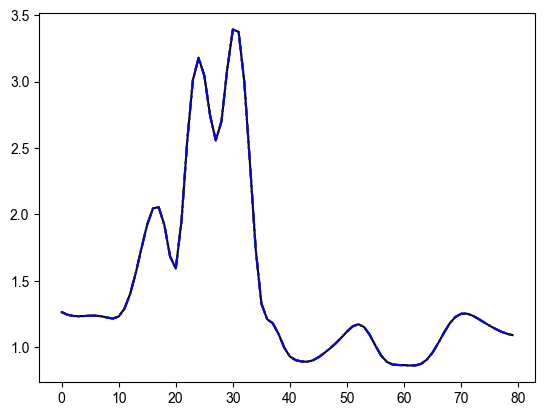

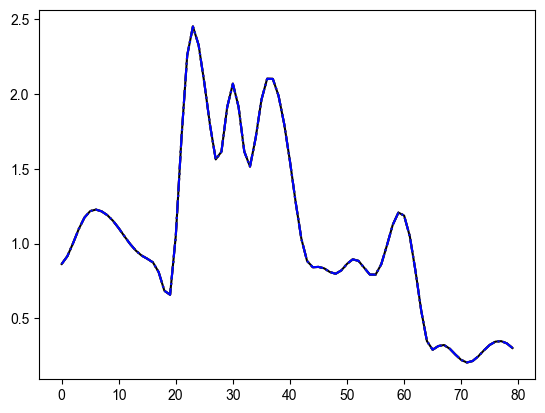

In [92]:
def calculate_magnitude(data, field='CHEST_Accel'):
    assert(isinstance(data, pd.DataFrame))
    a_x = data[field+'_X']
    a_y = data[field+'_Y']
    a_z = data[field+'_Z']
    a_a = np.sqrt(a_x**2 + a_y**2 + a_z**2)
    return a_a




plt.plot(calculate_magnitude(mdata,'CHEST_Accel'),'k')
plt.plot(calculate_magnitude(adata_1,'CHEST_Accel'),'r-.')
plt.plot(calculate_magnitude(adata_2,'CHEST_Accel'),'g-.')
plt.plot(calculate_magnitude(adata_3,'CHEST_Accel'),'b-.')

plt.figure()



plt.plot(calculate_magnitude(mdata,'CHEST_Gyro'),'k')
plt.plot(calculate_magnitude(adata_1,'CHEST_Gyro'),'r-.')
plt.plot(calculate_magnitude(adata_2,'CHEST_Gyro'),'g-.')
plt.plot(calculate_magnitude(adata_3,'CHEST_Gyro'),'b-.')



### Checking data loader

In [53]:
import sys
import os
sys.path.append("./../DeepDA")
from main import *


"""Get default arguments."""
parser = configargparse.ArgumentParser()
parser.add_argument('--labels_name',type=str,nargs='+')      # option that takes a value

args = parser.parse_args(args=[])


base_name = "norm_landing_data.hdf5"
prefix_name = "double_leg_"
tst = os.path.join("selection",prefix_name+base_name)
print(tst)
setattr(args, "tst_domain",tst)


# load the augmented subjects data

base_name = "norm_landing_data.hdf5"
prefix_name = "6rotid_double_leg_"
tre = os.path.join("augmentation",prefix_name+base_name)
print(tre)
setattr(args, "tre_domain",tre)

parser.set_defaults(data_dir=const.DATA_PATH)


#data path
args.data_dir = const.DATA_PATH

# features
features_name = const.extract_imu_fields(const.IMU_SENSOR_LIST, const.ACC_GYRO_FIELDS)
setattr(args, "features_name", features_name)
setattr(args, "n_labels", 1)
setattr(args, "labels_name", ["R_KNEE_MOMENT_X"])
setattr(args,'src_domain','None')
setattr(args,'tcl_domain','None')
setattr(args,'batch_size',1)
setattr(args,'num_workers',1)

#
# load multiple domain datasets
multiple_domain_datasets, _ = open_datafile(args)

selection/double_leg_norm_landing_data.hdf5
augmentation/6rotid_double_leg_norm_landing_data.hdf5


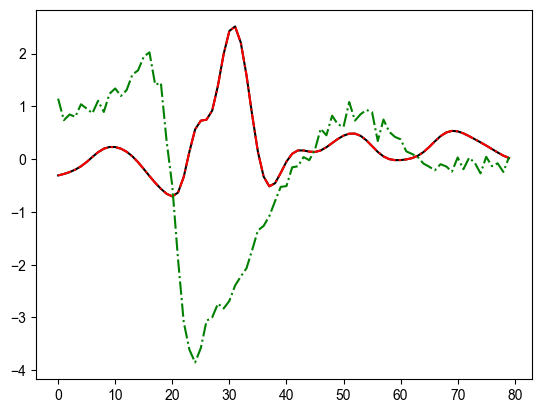

In [43]:
mdata1_1 = multiple_domain_datasets['tst'][subject_id_name][trial_id]
nonrot_trial_idx= 6
adata1_1 = multiple_domain_datasets['tre'][subject_id_name][trial_id+'_'+str(nonrot_trial_idx)]

plt.plot(mdata['CHEST_Accel_X'],'k')
plt.plot(mdata1_1['CHEST_Accel_X'],'r-.')
plt.plot(adata1_1['CHEST_Accel_X'],'g-.')

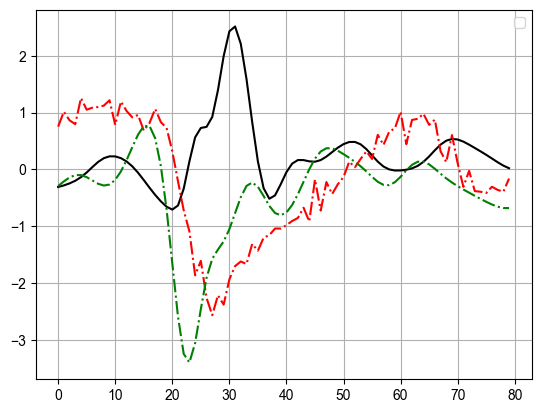

In [44]:
domain_data_loaders, n_labels = load_data(args, multiple_domain_datasets)


x1 = next(iter(domain_data_loaders['tre']))
y1 = next(iter(domain_data_loaders['tst']))


x11 = x1[0].squeeze().reshape(80,-1)
y11 = y1[0].squeeze().reshape(80,-1)

x111=x11.numpy()
y111=y11.numpy()


plt.plot(mdata['CHEST_Accel_X'],'k')
#plt.plot(mdata1_1['CHEST_Accel_X'],'r-.')
#plt.plot(adata1_1['CHEST_Accel_X'],'g')
plt.plot(x111[:,features_name.index('CHEST_Accel_X')],'r-.')
plt.plot(y111[:,features_name.index('CHEST_Accel_X')],'g-.')
plt.legend()
plt.grid()

# View data from an  image aspect

In [24]:
subjects_trials_dataset, _= pro_rd.load_subjects_dataset(h5_file_name = os.path.join(DATA_PATH,'selection','double_leg_norm_landing_data.hdf5'))

In [44]:
list_data[0]

array([[-0.3077433 , -0.8484833 ,  0.88640183, ..., -1.0304292 ,
        -0.4964204 , -2.0140865 ],
       [-0.2803715 , -0.80281615,  0.9104271 , ..., -1.0304292 ,
        -0.5679911 , -1.9245374 ],
       [-0.244814  , -0.7740207 ,  0.93206674, ..., -1.0304292 ,
        -0.6402941 , -1.8360376 ],
       ...,
       [ 0.12751731, -0.05637182,  1.1095148 , ...,  0.1169098 ,
        -0.8963578 , -1.0785342 ],
       [ 0.06789239, -0.07117046,  1.0978602 , ...,  0.10370211,
        -0.9057458 , -1.0697848 ],
       [ 0.02202019, -0.08120648,  1.0885221 , ...,  0.09304942,
        -0.9150232 , -1.0655061 ]], dtype=float32)

['CHEST_Accel_X', 'CHEST_Accel_Y', 'CHEST_Accel_Z', 'CHEST_Gyro_X', 'CHEST_Gyro_Y', 'CHEST_Gyro_Z', 'CHEST_Mag_X', 'CHEST_Mag_Y', 'CHEST_Mag_Z', 'WAIST_Accel_X', 'WAIST_Accel_Y', 'WAIST_Accel_Z', 'WAIST_Gyro_X', 'WAIST_Gyro_Y', 'WAIST_Gyro_Z', 'WAIST_Mag_X', 'WAIST_Mag_Y', 'WAIST_Mag_Z', 'R_THIGH_Accel_X', 'R_THIGH_Accel_Y', 'R_THIGH_Accel_Z', 'R_THIGH_Gyro_X', 'R_THIGH_Gyro_Y', 'R_THIGH_Gyro_Z', 'R_THIGH_Mag_X', 'R_THIGH_Mag_Y', 'R_THIGH_Mag_Z', 'R_SHANK_Accel_X', 'R_SHANK_Accel_Y', 'R_SHANK_Accel_Z', 'R_SHANK_Gyro_X', 'R_SHANK_Gyro_Y', 'R_SHANK_Gyro_Z', 'R_SHANK_Mag_X', 'R_SHANK_Mag_Y', 'R_SHANK_Mag_Z', 'R_FOOT_Accel_X', 'R_FOOT_Accel_Y', 'R_FOOT_Accel_Z', 'R_FOOT_Gyro_X', 'R_FOOT_Gyro_Y', 'R_FOOT_Gyro_Z', 'R_FOOT_Mag_X', 'R_FOOT_Mag_Y', 'R_FOOT_Mag_Z', 'L_THIGH_Accel_X', 'L_THIGH_Accel_Y', 'L_THIGH_Accel_Z', 'L_THIGH_Gyro_X', 'L_THIGH_Gyro_Y', 'L_THIGH_Gyro_Z', 'L_THIGH_Mag_X', 'L_THIGH_Mag_Y', 'L_THIGH_Mag_Z', 'L_SHANK_Accel_X', 'L_SHANK_Accel_Y', 'L_SHANK_Accel_Z', 'L_SHANK_Gyro_X

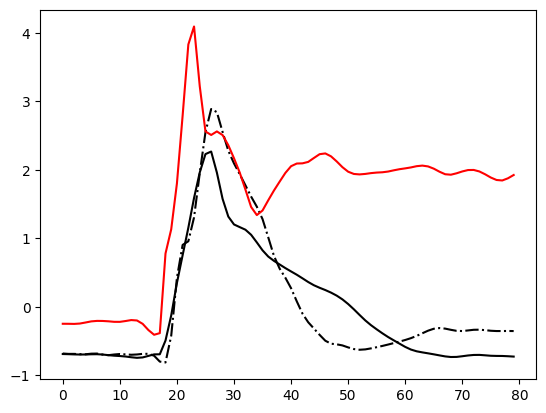

In [16]:
plt.plot(subjects_trials_dataset['P_08_zhangboyuan']['05']['R_KNEE_MOMENT_X'],'k-.')
plt.plot(subjects_trials_dataset['P_14_hunan']['04']['R_KNEE_MOMENT_X'],'k')
plt.plot(subjects_trials_dataset['P_14_hunan']['04']['R_KNEE_MOMENT_Y'],'r')
print(const.FEATURES_FIELDS)
subjects

tmp_data = subjects_trials_dataset['P_14_hunan']['04'][const.SELECTED_FEATURES_NAME].values

## Show features using image

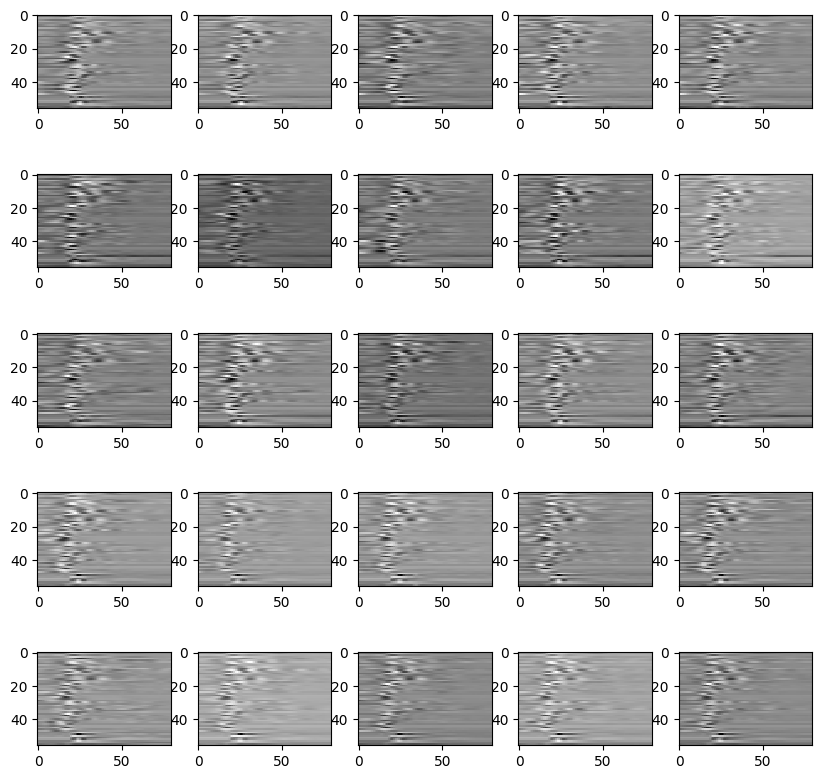

In [50]:
# 1. show featrues of measured dataset

subjects_trials = {subject_id_name: subjects_trials_dataset[subject_id_name].keys() for subject_id_name in subjects_trials_dataset.keys()} # get subjects_tials
subject_ids_names = subjects_trials.keys() # get subjects

#2) concate them into a numpy for scale
list_data = [subjects_trials_dataset[subject_id_name][trial].values for subject_id_name in subject_ids_names for trial in subjects_trials[subject_id_name]]

fig, axes = plt.subplots(5,5, figsize=(10,10))

for idx, ax in enumerate(axes.flat):
    ax.imshow(list_data[idx].T, interpolation='nearest', cmap='gray')

/media/sun/TFcard/drop_landing_workspace/data/augmentation/6rotid_double_leg_norm_landing_data.hdf5


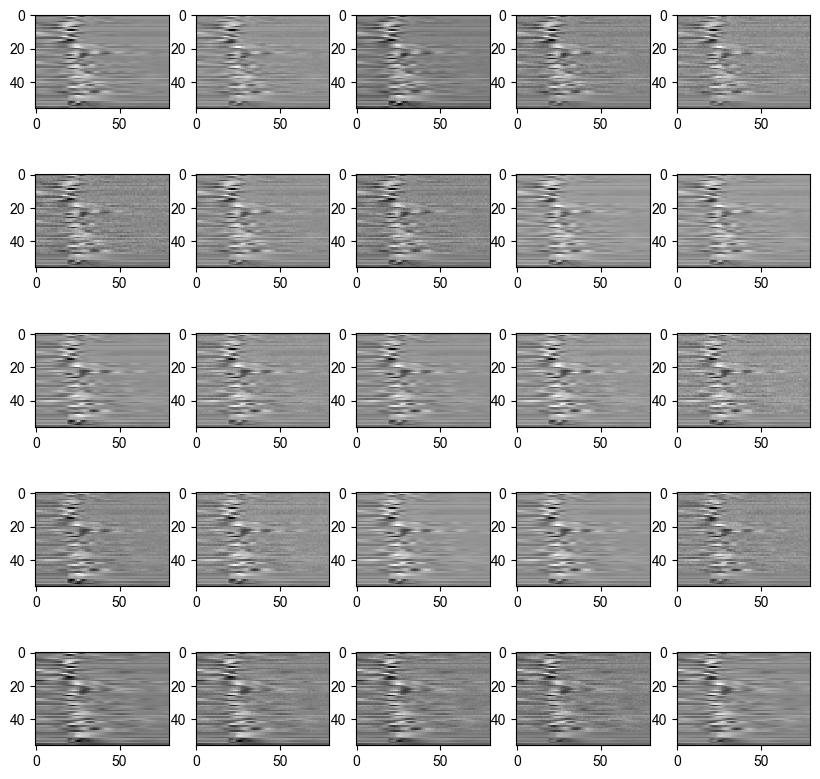

In [5]:
# 2. show featrues of augmentaed dataset

base_name = "norm_landing_data.hdf5"
prefix_name = "6rotid_double_leg_"
h5_file_name = os.path.join(DATA_PATH,"augmentation",prefix_name+base_name)
print(h5_file_name)
augmented_subjects_trials_dataset, _ = pro_rd.load_subjects_dataset(h5_file_name=h5_file_name)


subjects_trials = {subject_id_name: augmented_subjects_trials_dataset[subject_id_name].keys() for subject_id_name in augmented_subjects_trials_dataset.keys()} # get subjects_tials
subject_ids_names = subjects_trials.keys() # get subjects

#2) concate them into a numpy for scale
list_data = [augmented_subjects_trials_dataset[subject_id_name][trial].values for subject_id_name in subject_ids_names for trial in subjects_trials[subject_id_name]]

fig, axes = plt.subplots(5,5, figsize=(10,10))

for idx, ax in enumerate(axes.flat):
    ax.imshow(list_data[idx].T, interpolation='nearest', cmap='gray')